## For Colab:
Run the following cell to let Google colab access your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## For Using TensorBoard in Colab:
TensorBoard provides the visualization and tooling needed for machine learning experimentation.

In [ ]:
!pip install tensorboardcolab

In [ ]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

# the link does not work on a Amrita connect.

***
## The Imports:

In [2]:
import sys, os
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import model_from_json
from keras.utils import np_utils
import matplotlib.pyplot as plt

###  The Facial Expression Recognition 2013 (FER-2013) Dataset
* The data consists of 48x48 pixel grayscale images of faces. 

* The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. 

In [3]:
df=pd.read_csv('fer2013.csv')
# for colab, use:
# df=pd.read_csv('gdrive/My Drive/Emotion Recognition/fer2013.csv')
print(df.info())
print(df["Usage"].value_counts())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


## Are the classes balanced?

### The classes are:

1. Angry
2. Diguist
3. Fear
4. Happy
5. Sad
6. Surprise
7. Neutral

Text(0.5, 0.98, 'Data distribution')

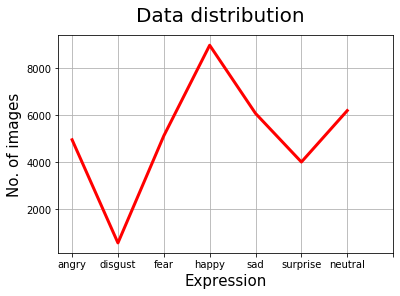

In [4]:
import csv
with open('fer2013.csv', 'r') as f:
  reader = csv.reader(f)
  your_list = list(reader)
c=0
count_list=[0,0,0,0,0,0,0]
for a in your_list[1:]:
    x= int(a[0])
    count_list[x]=count_list[x]+1
    
x_ax=[0,1,2,3,4,5,6]
fig = plt.figure()
plt.grid()
plt.plot(x_ax, count_list, linewidth=3, linestyle="-", c="r")

positions = [0,1,2,3,4,5,6,7]
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plt.xticks(positions, labels)
plt.xlabel('Expression', fontsize=15)
plt.ylabel('No. of images', fontsize=15)
fig.suptitle('Data distribution', fontsize=20)

## The Pie Chart:

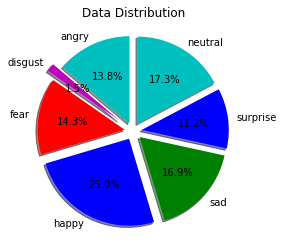

In [48]:
slices = [count_list[0], count_list[1], count_list[2], count_list[3], count_list[4], count_list[5], count_list[6]]
activities = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
cols = ['c','m','r','b', 'g', 'b']

plt.pie(slices,
        labels=activities,
        colors=cols,
        startangle=90,
        shadow= True,
        explode=(0.1,0.2,0.1,0.1,0.1,0.1,0.1),
        autopct='%1.1f%%')

plt.title('Data Distribution')
plt.show()

I trained the model without balancing the data, as a result it is very good at detecting Happy and Neutral faces, but it struggles to detect Disguist and Anger. 

### Solution: 
* Balance the dataset

In [15]:
print("Angry:",count_list[0])
print("Disguist:",count_list[1])
print("Fear:",count_list[2])
print("Happy:", count_list[3])
print("Sad:", count_list[4])
print("Surprise:", count_list[5])
print("Neutral:", count_list[6])

Angry: 4953
Disguist: 547
Fear: 5121
Happy: 8989
Sad: 6077
Surprise: 4002
Neutral: 6198


           The dataset is clearly unbalanced. 

***

## Create a directory to store images:

* Not required if you just want to run the model

In [ ]:
mkdir fer_images

## Convert CSV to images, and save:
* Run only if you want to visualise the training data.

In [54]:
fer_data=pd.read_csv('./fer2013.csv',delimiter=',')
def save_fer_img():
    print("Please wait...")

    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        pathname=os.path.join('fer_images',str(index)+'.jpg')
        cv2.imwrite(pathname,img)
    print("Done")   

In [ ]:
save_fer_img() 

## Visualising the Training images:

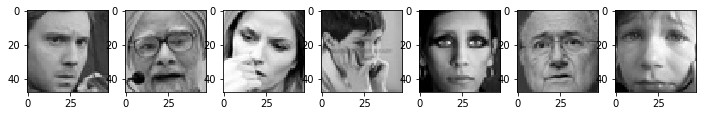

In [13]:
fig, axs = plt.subplots(1, 7, figsize=(12,2))
for i in range(7):
    path = './fer_images/'+str(i)+'.jpg'
    img2 = cv2.imread(path)
    axs[i].imshow(img2)

                  Is that Manmohan Singh?
***               
               

## The Model:
* Run this cell, wether you train the model (locally or on colab) or load the existing model

In [6]:
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")

        
    
num_features = 64
num_labels = 7
batch_size = 64
epochs = 30
width, height = 48, 48


X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

## Model Summmary:

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

## Compliling the model:
* Not required if you are planning to load the model (rather than training it).

In [4]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

## Train the model:
* Run the Following cell to train the model locally.
* If you have already trained the model, load it.

In [ ]:
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)

## To train in colab, use:

In [ ]:
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True,
          callbacks=[TensorBoardColabCallback(tbc)])

## Save the model for future use:

In [ ]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

## Load model:

In [7]:
#load model
model = model_from_json(open("./model/fer.json", "r").read())
#load weights
model.load_weights('./model/fer.h5')
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

***
## How does it perform on images?

Try out:
1. Mona_lisa.jpg
2. Neutral_guy.jpg
3. Smiling_Bob_Ross.jpg
4. Surprised_guy.jpg

Change the path below:


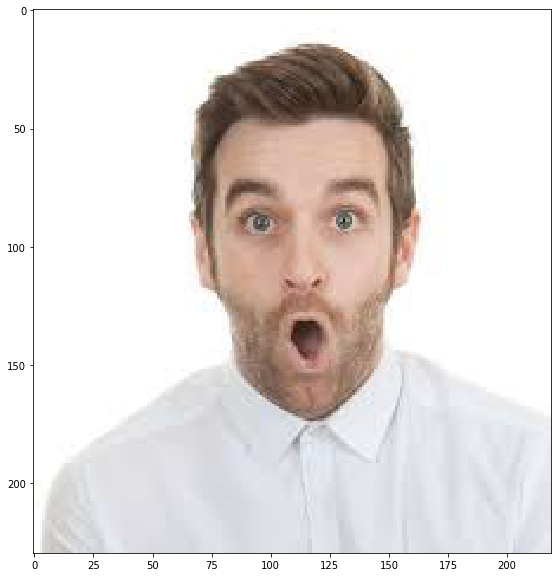

In [35]:
path = './Surprised_guy.jpg'


IMG_SIZE=100
test_img2 = cv2.imread(path)
plt.figure(figsize = (10,10))
plt.axis('on')
plt.imshow(test_img2)

# To fix weird colors
RGB_img = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

### Pass the Image through the model:

In [36]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray_img= cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img2,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255
        
        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img2, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        resized_img = cv2.resize(test_img2, (1000, 700))

        filename = 'savedImage.jpg'
        cv2.imwrite(filename, test_img2) 

        print(predicted_emotion)
        print(predictions[0])

surprise
[4.0920754e-03 5.2092609e-08 3.3129834e-02 1.4411394e-02 9.7974007e-05
 9.4706267e-01 1.2060195e-03]


### The Prediction:

Text(0.5, 1.0, 'surprise')

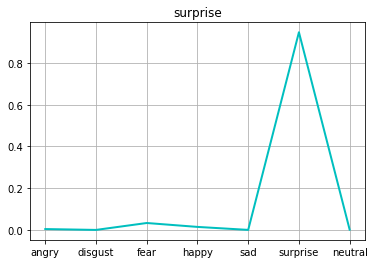

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
x_coords = predictions[0]
positions = [0,1,2,3,4,5,6,7]
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plt.xticks(positions, labels)
plt.grid()
plt.plot(x_coords, linewidth=2, linestyle="-", c="c")
plt.title(predicted_emotion)

## Open the saved image:



/home/mainak09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


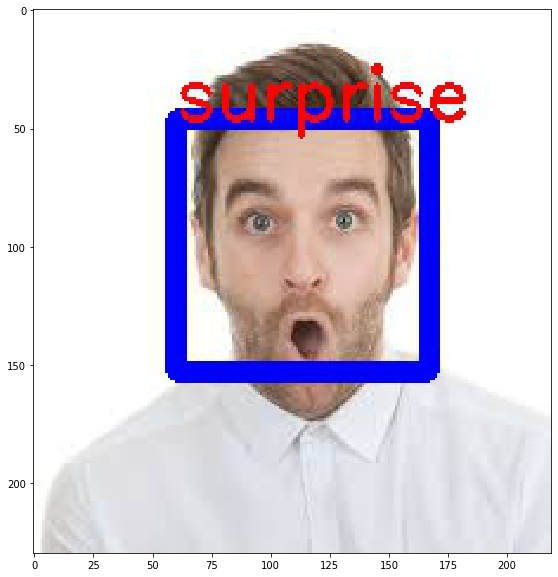

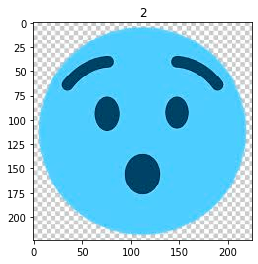

In [39]:
path = './savedImage.jpg'
test_img4 = cv2.imread(path)

plt.figure(figsize = (20,10))
plt.axis('on')

RGB_img = cv2.cvtColor(test_img4, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
fig = plt.figure()
ax = fig.gca()
fig.show()
ii=2
#('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
if max_index == 0:
    path = './emojis/angry.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    
if max_index == 1:
    path = './emojis/disguist.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    

if max_index == 2:
    path = './emojis/fear.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    

if max_index == 3:
    path = './emojis/happy.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    
    
if max_index == 4:
    path = './emojis/sad.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    

if max_index == 5:
    path = './emojis/surprise.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    
if max_index == 6:
    path = './emojis/neutral.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()

***
## Run the trained model live via the webcam:

* Runs pretty well on well lit conditions.
* Do not press any key (or move the cursor) while it runs.
* Press Q to stop.
* If that doesn't work, interrupt the kernel.

In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

# Dont forget to load the model

face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


cap=cv2.VideoCapture(0)

while True:
    
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (700, 500))
    cv2.imshow('Facial emotion analysis ',resized_img)


    if cv2.waitKey(10) == ord('q'):
        #wait until 'q' key is pressed
        
        
        cv2.destroyAllWindows
        break

cap.release()


## Attempting to display corresponding emoji with video feed:

### Warning, the cell below does not work, it might freeze your pc
* Does not work, keeps creating new windows
* Even if I close the windows, the performance is extremely bad
* Will try to run this in colab

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

cap=cv2.VideoCapture(0)

while True:
    
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        #print(predicted_emotion)
        
        fig = plt.figure()
        ax = fig.gca()
        fig.show()
        ii=2
        #('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        if max_index == 0:
            path = './emojis/angry.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)
            
        if max_index == 1:
            path = './emojis/disguist.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)
            
        if max_index == 2:
            path = './emojis/fear.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)
            
        if max_index == 3:
            path = './emojis/happy.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)
        if max_index == 4:
            path = './emojis/sad.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)
            
        if max_index == 5:
            path = './emojis/surprise.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)
            
        if max_index == 6:
            path = './emojis/neutral.png'
            im = cv2.imread(path)
            plt.imshow(im, interpolation='None')
            ax.set_title(ii)
            fig.canvas.draw()
            sleep(0.1)

    resized_img = cv2.resize(test_img, (700, 500))
    cv2.imshow('Facial emotion analysis ',resized_img)

    if cv2.waitKey(10) == ord('q'):
        #wait until 'q' key is pressed
        
        
        cv2.destroyAllWindows
        break

cap.release()


***
## Workaround:
* Open webcam.
* Snap a photo.
* Pass it through the model.
* Display the corresponding emoji.
***

## Run the cell below to snap an image using the webcam:
* Interrupt the kernel to save the image.

In [206]:
import cv2 
import matplotlib.pyplot as plt
key = cv2. waitKey(1)
webcam = cv2.VideoCapture(0)
while True:
    try:
        check, frame = webcam.read()
        #print(check) #prints true as long as the webcam is running
        #print(frame) #prints matrix values of each framecd 
        cv2.imshow("Capturing", frame)
        filename = 'saved_Image3.jpg'
        cv2.imwrite(filename, frame) 
        key = cv2.waitKey(1)
        
        
    except(KeyboardInterrupt):
        print("Turning off camera.....")
        webcam.release()
        print("Camera off.")
        print("Program Terminated")
        print("Image saved as saved_Image3.jpg ")
        cv2.destroyAllWindows()
        break


Turning off camera.....
Camera off.
Program Terminated
Image saved as saved_Image3.jpg 


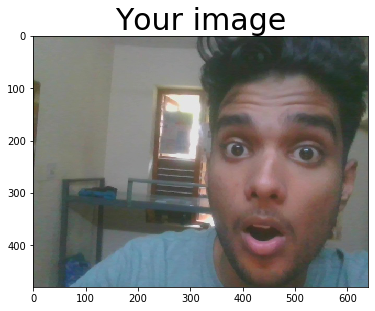

In [207]:
path = './saved_Image3.jpg'
test_img3 = cv2.imread(path)
plt.figure(figsize = (6,6))
plt.axis('on')
plt.title("Your image", fontsize=30)

# To fix the weird color issue.
RGB_img = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

## Pass it through the model:


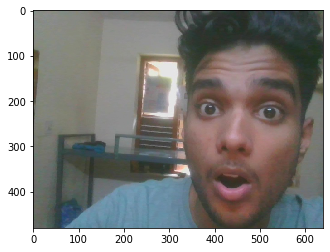

surprise


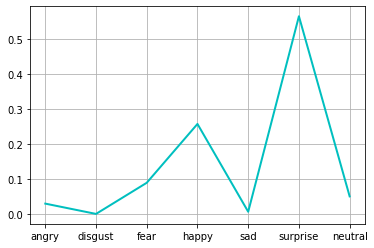

In [208]:
RGB_img = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray_img= cv2.cvtColor(test_img3, cv2.COLOR_BGR2GRAY)
faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img3,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255
        
        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img3, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        resized_img = cv2.resize(test_img3, (1000, 700))

        filename = 'savedImage3.jpg'
        cv2.imwrite(filename, test_img3) 
        
        #open savedImage.jpg
        print(predicted_emotion)
        #print(predictions[0])
        
x_coords = predictions[0]
########################################
positions = [0,1,2,3,4,5,6,7]
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plt.xticks(positions, labels)
plt.grid()
plt.plot(x_coords, linewidth=2, linestyle="-", c="c")        
        

NOTE: The model seems to be biased towards neutral and happy, balancing the training data might help.

## Display the corresponding Emoji:

/home/mainak09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


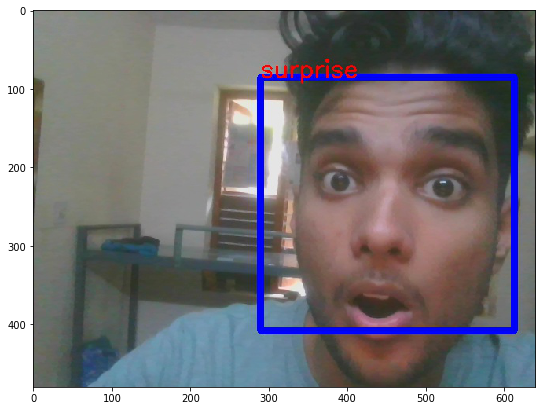

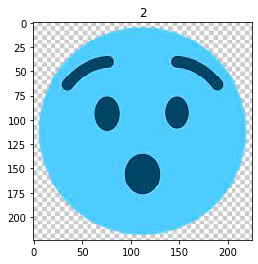

In [210]:
path = './savedImage3.jpg'
test_img4 = cv2.imread(path)

plt.figure(figsize = (9,9))
plt.axis('on')

RGB_img = cv2.cvtColor(test_img4, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)




fig = plt.figure()
ax = fig.gca()
fig.show()
ii=2
#('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
if max_index == 0:
    path = './emojis/angry.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    
if max_index == 1:
    path = './emojis/disguist.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    

if max_index == 2:
    path = './emojis/fear.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    

if max_index == 3:
    path = './emojis/happy.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    
    
if max_index == 4:
    path = './emojis/sad.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    

if max_index == 5:
    path = './emojis/surprise.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
    
if max_index == 6:
    path = './emojis/neutral.png'
    im = cv2.imread(path)
    plt.imshow(im, interpolation='None')
    ax.set_title(ii)
    fig.canvas.draw()
  


## To Do:
* Display emoji with live webcam feed.
* Balance out the classes in training data.
* Fix the neutral and happy bias.
* Plot the Confusion matrix.
